## Loading and preprocessing data

Since time-based information is crucial for electricity demand forecasting, we extract features such as:

- Hour of the day – Captures daily demand patterns.
- Day of the week – Accounts for weekday vs. weekend variations.
- Month – Helps identify seasonal trends.

The original timestamp is dropped since the extracted features contain the relevant time-related information. Finally, the dataset is split into features (X) and target variable (y), where the target variable represents the actual electricity load.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set Global Random Seed for Reproducibility
np.random.seed(42)

# Load dataset
file_path = '../data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime and set as index
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)  # Set as index instead of dropping

# Extract time-based features
data['hour'] = data.index.hour  # Hour of the day (0-23)
data['day_of_week'] = data.index.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['month'] = data.index.month  # Month (1-12)

# Store the timestamps separately
timestamps = data.index

# Features (X) and target variable (y)
X = data.drop(columns=['DE_load_actual_entsoe_transparency']).values  # Feature matrix
y = data['DE_load_actual_entsoe_transparency'].values  # Target variable

## Data Splitting and standardization

To ensure the model is trained, validated, and tested correctly, we divide the dataset into three parts:

- Training set (70%) – Used to train the model.
- Validation set (15%) – Used to fine-tune hyperparameters.
- Test set (15%) – Used to evaluate the final model's performance.

Since Kernel Ridge Regression is sensitive to the scale of features, we apply standardization using StandardScaler(). Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which improves the model’s stability and performance.

In [4]:
# Data split - sequential (chronological) order with fixed percentages
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Get corresponding timestamps for each split
train_timestamps = timestamps[:train_size]
val_timestamps = timestamps[train_size:train_size+val_size]
test_timestamps = timestamps[train_size+val_size:]

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
print(f"Test period: {test_timestamps.min()} to {test_timestamps.max()}")

# Standardize Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training size: 30676, Validation size: 6573, Test size: 6575
Test period: 2019-04-02 01:00:00+00:00 to 2019-12-31 23:00:00+00:00


## Model Training


## Linear Kernel 

The linear kernel assumes that there is a simple linear relationship between input features

Alpha=0.1 → Validation MAPE: 0.9972
Alpha=1.0 → Validation MAPE: 0.9972
Alpha=10.0 → Validation MAPE: 0.9972

Best Alpha: 0.1, Best Validation MAPE: 0.9972

Final Test MAPE for Linear Kernel: 1.0613
Final Test MAE: 56230.8551
Final Test RMSE: 56268.9953
Final Test R² Score: -32.8374


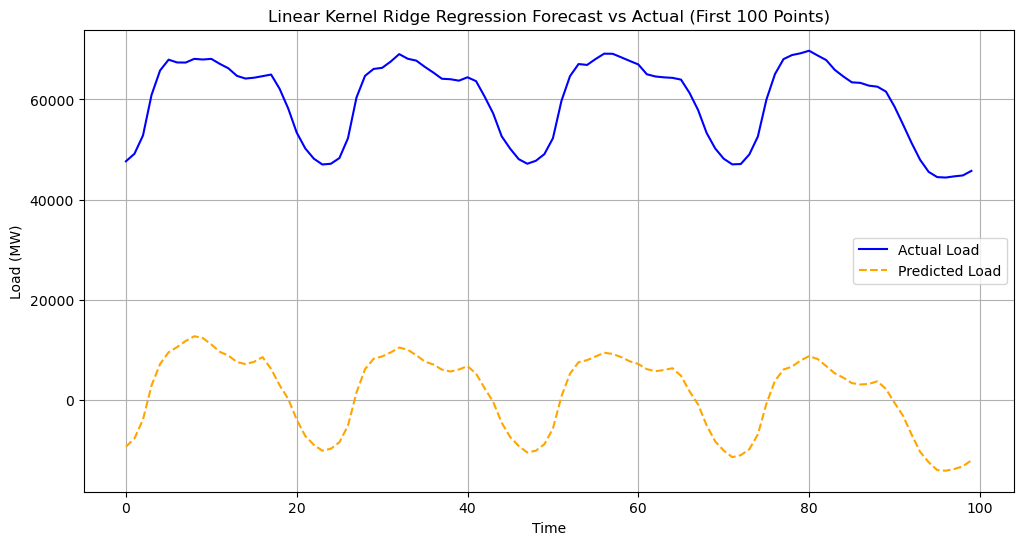

In [5]:
# Step 1: Tune Alpha Using the Validation Set (No Gamma for Linear Kernel)
best_alpha, best_mape = None, float("inf")
alpha_values = [0.1, 1.0, 10.0]

for alpha in alpha_values:
    krr = KernelRidge(kernel='linear', alpha=alpha)
    krr.fit(X_train_scaled, y_train)
    val_predictions = krr.predict(X_val_scaled)
    val_mape = mape(y_val, val_predictions)
    print(f"Alpha={alpha} → Validation MAPE: {val_mape:.4f}")
    if val_mape < best_mape:
        best_alpha, best_mape = alpha, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model on Best Alpha
final_krr = KernelRidge(kernel='linear', alpha=best_alpha)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Model on Unseen Test Data
test_predictions = final_krr.predict(X_test_scaled)

test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE for Linear Kernel: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Step 4: Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Linear Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

- Electricty load typically follows a pattern, but is also influenced by non-linear dependencies like seasonality, holidays etc.
- Since the relationship is not purely linear the, this model struggles to capture the variations properly.
- Results show this model is terrible with a MAPE of 1.03 (103%)

## RBF Kernel 

The RBF kernel is a flexible non-linear model that maps input features into an infinite dimensional feature space. It treats similar time-based input values as close neighbors and learns patterns accordingly.

Alpha=0.1, Gamma=0.01 → Validation MAPE: 0.0248
Alpha=0.1, Gamma=0.1 → Validation MAPE: 0.0243
Alpha=0.1, Gamma=1.0 → Validation MAPE: 0.0253
Alpha=1.0, Gamma=0.01 → Validation MAPE: 0.0254
Alpha=1.0, Gamma=0.1 → Validation MAPE: 0.0253
Alpha=1.0, Gamma=1.0 → Validation MAPE: 0.0266
Alpha=10.0, Gamma=0.01 → Validation MAPE: 0.0282
Alpha=10.0, Gamma=0.1 → Validation MAPE: 0.0283
Alpha=10.0, Gamma=1.0 → Validation MAPE: 0.0389

Best Alpha: 0.1, Best Gamma: 0.1, Best Validation MAPE: 0.0243

Final Test MAPE: 0.0289
Final Test MAE: 1551.4718
Final Test RMSE: 1946.2378
Final Test R² Score: 0.9595


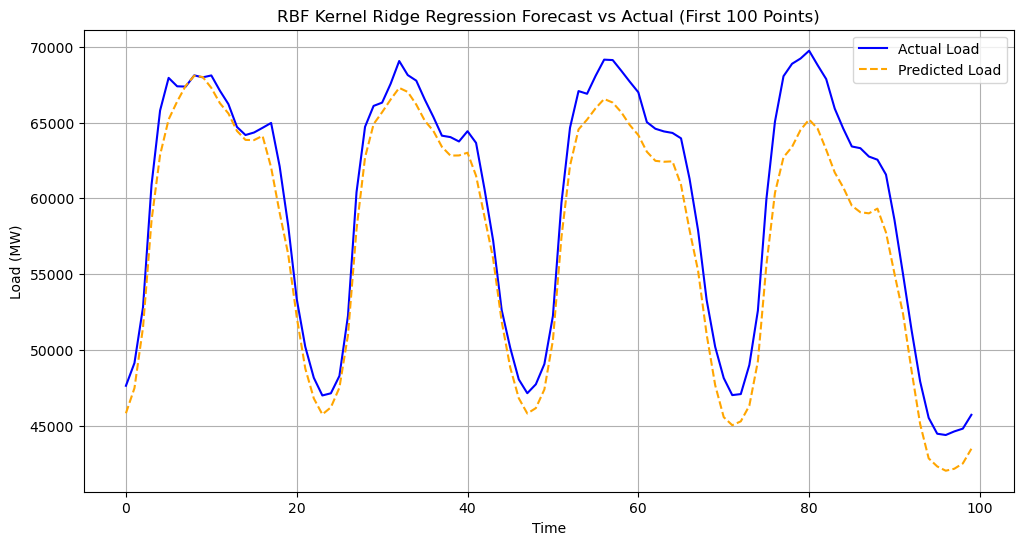

In [6]:
# Step 1: Tune Alpha & Gamma Using the Validation Set
best_alpha, best_gamma, best_mape = None, None, float("inf")

alpha_values = [0.1, 1.0, 10.0]
gamma_values = [0.01, 0.1, 1.0]

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
        krr.fit(X_train_scaled, y_train)
        val_predictions = krr.predict(X_val_scaled)
        val_mape = mape(y_val, val_predictions)

        print(f"Alpha={alpha}, Gamma={gamma} → Validation MAPE: {val_mape:.4f}")

        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model
final_krr = KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Final Model
test_predictions = final_krr.predict(X_test_scaled)

test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Step 4: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("RBF Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

- Electricity load is driven by many factors such as time
- The RBF kernel performs very well in capturing these dependencies 
- Results show that MAPE is at 0.022 (2.2%)

Number of data points in selected period: 120

KRR (RBF Kernel) - June 3-7, 2019 Metrics:
MAPE: 0.0369
MAE: 2116.1253 MW
RMSE: 2428.6691 MW
R²: 0.9185


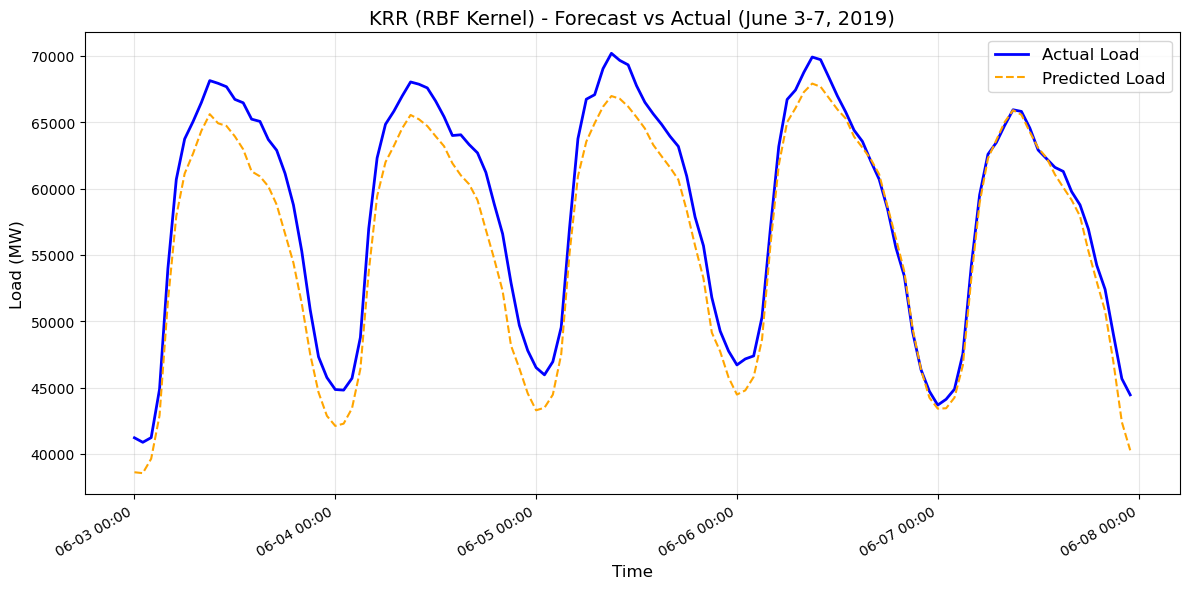

In [7]:
test_results = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions
}, index=test_timestamps)

# Define date range for June 3-7, 2019
start_date = '2019-06-03'
end_date = '2019-06-07 23:59:59'

# Filter to June 3-7, 2019
filtered_data = test_results.loc[start_date:end_date]
print(f"Number of data points in selected period: {len(filtered_data)}")

# Create the standardized visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['actual'], label="Actual Load", color="blue", linewidth=2)
plt.plot(filtered_data.index, filtered_data['predicted'], label="Predicted Load", color="orange", linestyle="dashed")

# Set title and labels with consistent formatting
plt.title("KRR (RBF Kernel) - Forecast vs Actual (June 3-7, 2019)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Load (MW)", fontsize=12)

# Format x-axis for better date display
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate metrics for June 3-7, 2019
period_mape = mape(filtered_data['actual'], filtered_data['predicted'])
period_mae = mean_absolute_error(filtered_data['actual'], filtered_data['predicted'])
period_rmse = np.sqrt(mean_squared_error(filtered_data['actual'], filtered_data['predicted']))
period_r2 = r2_score(filtered_data['actual'], filtered_data['predicted'])

print(f"\nKRR (RBF Kernel) - June 3-7, 2019 Metrics:")
print(f"MAPE: {period_mape:.4f}")
print(f"MAE: {period_mae:.4f} MW")
print(f"RMSE: {period_rmse:.4f} MW")
print(f"R²: {period_r2:.4f}")

Number of data points on June 5th: 24

Hourly Results for KRR (RBF Kernel) - June 5, 2019:
 Hour  Actual Load (MW)  Predicted Load (MW)  Absolute Error (MW)  Percentage Error (%)
    0           46510.0             43291.21              3218.79                  6.92
    1           45963.0             43484.01              2478.99                  5.39
    2           46954.0             44466.75              2487.25                  5.30
    3           49548.0             47502.50              2045.50                  4.13
    4           57040.0             55135.82              1904.18                  3.34
    5           63757.0             60921.16              2835.84                  4.45
    6           66735.0             63538.49              3196.51                  4.79
    7           67076.0             64928.11              2147.89                  3.20
    8           69040.0             66171.71              2868.29                  4.15
    9           70194.0      

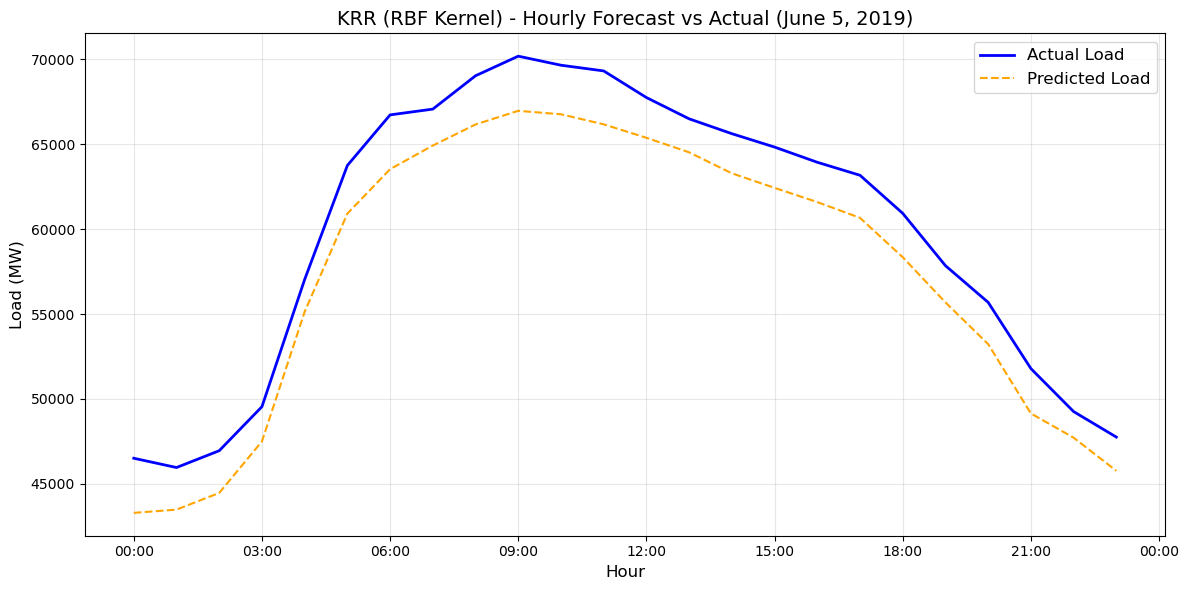

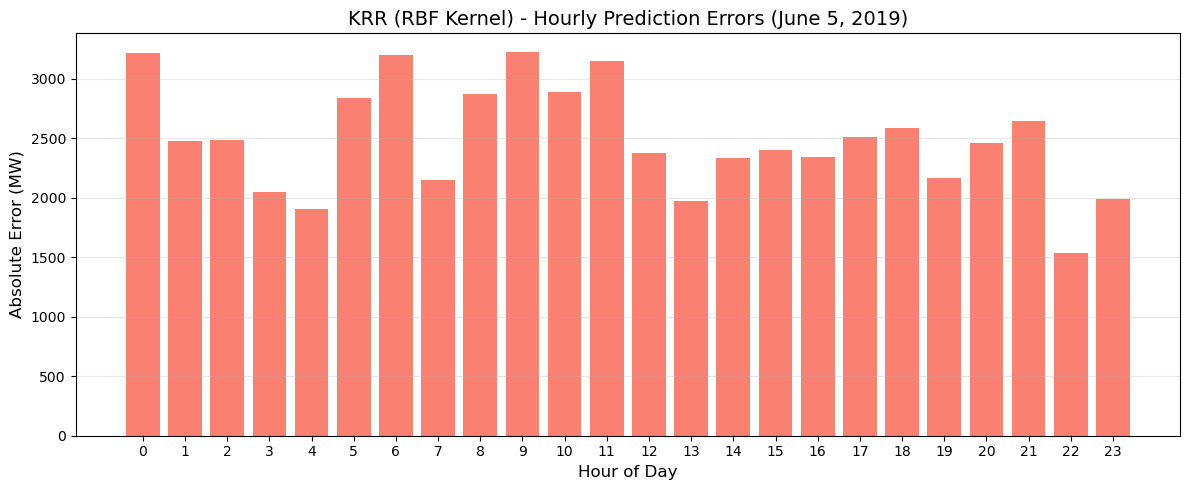

In [8]:
# Detailed hourly analysis for June 5th, 2019
specific_date = '2019-06-05'

# Filter to just June 5th data
june_5th_data = test_results.loc[specific_date]
print(f"Number of data points on June 5th: {len(june_5th_data)}")

# Create a DataFrame with hourly results
hourly_results = pd.DataFrame({
    'Hour': june_5th_data.index.hour,
    'Actual Load (MW)': june_5th_data['actual'].values,
    'Predicted Load (MW)': june_5th_data['predicted'].values
})

# Calculate hourly errors
hourly_results['Absolute Error (MW)'] = abs(hourly_results['Actual Load (MW)'] - hourly_results['Predicted Load (MW)'])
hourly_results['Percentage Error (%)'] = (hourly_results['Absolute Error (MW)'] / hourly_results['Actual Load (MW)']) * 100

# Format to 2 decimal places for better readability
hourly_results['Actual Load (MW)'] = hourly_results['Actual Load (MW)'].round(2)
hourly_results['Predicted Load (MW)'] = hourly_results['Predicted Load (MW)'].round(2)
hourly_results['Absolute Error (MW)'] = hourly_results['Absolute Error (MW)'].round(2)
hourly_results['Percentage Error (%)'] = hourly_results['Percentage Error (%)'].round(2)

# Display the hourly results as a table
print(f"\nHourly Results for KRR (RBF Kernel) - June 5, 2019:")
print(hourly_results.to_string(index=False))

# Calculate summary statistics
avg_error = hourly_results['Absolute Error (MW)'].mean()
max_error = hourly_results['Absolute Error (MW)'].max()
max_error_hour = hourly_results.loc[hourly_results['Absolute Error (MW)'].idxmax(), 'Hour']
min_error = hourly_results['Absolute Error (MW)'].min()
min_error_hour = hourly_results.loc[hourly_results['Absolute Error (MW)'].idxmin(), 'Hour']

print(f"\nSummary Statistics for June 5, 2019:")
print(f"Average Absolute Error: {avg_error:.2f} MW")
print(f"Maximum Error: {max_error:.2f} MW (Hour {max_error_hour})")
print(f"Minimum Error: {min_error:.2f} MW (Hour {min_error_hour})")

# Create visualization of hourly actual vs. predicted load
plt.figure(figsize=(12, 6))
plt.plot(june_5th_data.index, june_5th_data['actual'], label="Actual Load", color="blue", linewidth=2)
plt.plot(june_5th_data.index, june_5th_data['predicted'], label="Predicted Load", color="orange", linestyle="dashed")

plt.title(f"KRR (RBF Kernel) - Hourly Forecast vs Actual (June 5, 2019)", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Load (MW)", fontsize=12)

# Format x-axis to show hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=0)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize hourly errors
plt.figure(figsize=(12, 5))
plt.bar(hourly_results['Hour'], hourly_results['Absolute Error (MW)'], color='salmon')
plt.title(f"KRR (RBF Kernel) - Hourly Prediction Errors (June 5, 2019)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Absolute Error (MW)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Polynomial Kernel

The polynomial kernel captures non-linear relationships by raising input features to a power.

Alpha=0.1, Gamma=0.01, Degree=3 → Validation MAPE: 0.0248
Alpha=0.1, Gamma=0.1, Degree=3 → Validation MAPE: 0.0251
Alpha=0.1, Gamma=1.0, Degree=3 → Validation MAPE: 0.0251
Alpha=1.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0249
Alpha=1.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0250
Alpha=1.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0251
Alpha=10.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0251
Alpha=10.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0247
Alpha=10.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0250

Best Alpha: 10.0, Best Gamma: 0.1, Best Validation MAPE: 0.0247

Final Test MAPE: 0.0304
Final Test MAE: 1636.3956
Final Test RMSE: 2062.2736
Final Test R² Score: 0.9545


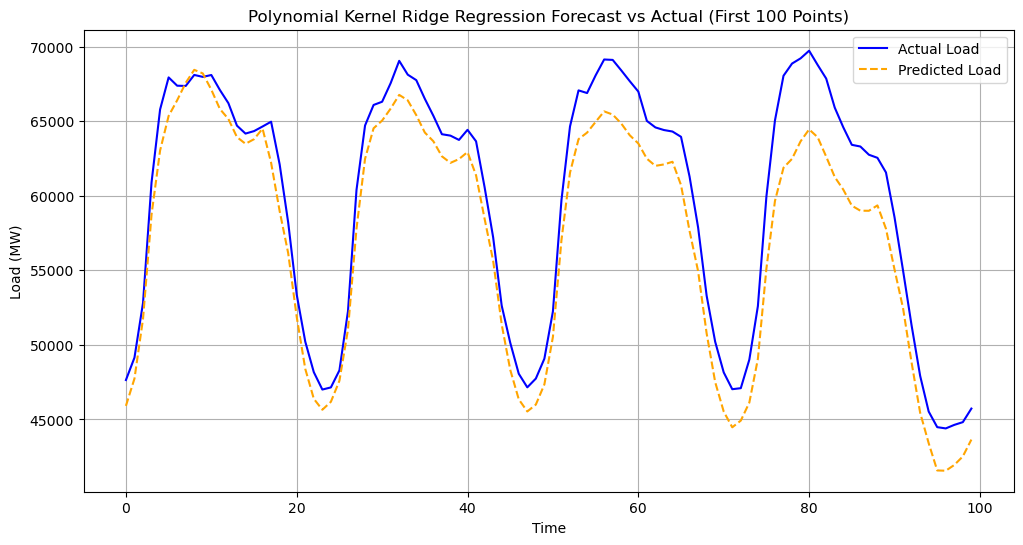

In [9]:
best_alpha, best_gamma, best_mape = None, None, float("inf")
degree = 3

alpha_values = [0.1, 1.0, 10.0]
gamma_values = [0.01, 0.1, 1.0]

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='poly', alpha=alpha, gamma=gamma, degree=degree)
        krr.fit(X_train_scaled, y_train)
        val_predictions = krr.predict(X_val_scaled)
        val_mape = mape(y_val, val_predictions)
        print(f"Alpha={alpha}, Gamma={gamma}, Degree={degree} → Validation MAPE: {val_mape:.4f}")
        
        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

final_krr_poly = KernelRidge(kernel='poly', alpha=best_alpha, gamma=best_gamma, degree=degree)
final_krr_poly.fit(X_train_scaled, y_train)

test_predictions_poly = final_krr_poly.predict(X_test_scaled)

test_mape_poly = mape(y_test, test_predictions_poly)
test_mae_poly = mean_absolute_error(y_test, test_predictions_poly)
test_rmse_poly = np.sqrt(mean_squared_error(y_test, test_predictions_poly))
test_r2_poly = r2_score(y_test, test_predictions_poly)

print(f"\nFinal Test MAPE: {test_mape_poly:.4f}")
print(f"Final Test MAE: {test_mae_poly:.4f}")
print(f"Final Test RMSE: {test_rmse_poly:.4f}")
print(f"Final Test R² Score: {test_r2_poly:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions_poly[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Polynomial Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


- If the relationship between time features and electricity load follow a structured pattern it will be useful
- The Polynomial Kernal found a strong correlation btween time and electricity load
- Results show Mape is 0.026 (2.6%)

## Analysis

- Linear KRR failed due to its inability to capture complex demand variations. It also had the highest MAPE value over 1
- RBF KRR performed the best, indicating electricity load follows highly non-linear trends with the lowest MAPE of 0.022
-  Polynomial KRR performed decently, but not as well as RBF due to its rigid structure. Has the second lowest MAPE of 0.026